In [2]:
print("Importing Library...")
import torch
import torchvision
import torch.utils.data as putils
import matplotlib.pyplot as plt

from torch import nn, optim
from torchvision import datasets,transforms
from torch.autograd import Variable
from PIL import Image
from google.colab import drive

import numpy
import numpy as np
import math


print("Importing Library Success")

Importing Library...
Importing Library Success


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [10]:
print("Defining Class...")
class ComCNN(nn.Module):
    def __init__(self, channel):
        super(ComCNN, self).__init__()
        self.conv1 = nn.Conv2d(channel, out_channels=64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1)
        self.bn1 = nn.BatchNorm2d(64, affine=False)
        self.conv3 = nn.Conv2d(64, channel, kernel_size=3, padding=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.relu(self.conv1(x))
        out = self.relu(self.bn1(self.conv2(out)))
        return self.conv3(out)

class MinMaxCNN(nn.Module):
    def __init__(self, channel,interpolate_size=2,mode='bicubic',deep=3):
        super(MinMaxCNN, self).__init__()
        self.deconv1 = nn.Conv2d(channel, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64, affine=False)
        self.deconv_n = nn.Conv2d(in_channels=64, out_channels=64,kernel_size=3, padding=1)
        self.bn_n = nn.BatchNorm2d(64, affine=False)
        self.deconv3 = nn.ConvTranspose2d(64, 2, kernel_size=3, padding=1)
        self.maxpool = nn.MaxPool2d(kernel_size=3,stride=1,padding=1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.interpolate_size = interpolate_size
        self.mode = mode

    def forward(self, x):
        # out = self.interpolate(x)
        out = x
        out = self.relu(self.deconv1(x))
        out = self.relu(self.bn_n(self.deconv_n(out)))
        out = (self.deconv3(out))
        out = self.maxpool(out)
        return self.sigmoid(out)
    
    def interpolate(self,x):
        return nn.functional.interpolate(input=x, scale_factor=self.interpolate_size, mode=self.mode,
                                         align_corners=False)

class BitmapRecCNN(nn.Module):
    def __init__(self, channel,interpolate_size=2,mode='bicubic',deep=3):
        super(BitmapRecCNN, self).__init__()
        self.deconv1 = nn.Conv2d(channel, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64, affine=False)
        self.deconv_n = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.bn_n = nn.BatchNorm2d(64, affine=False)
        self.deconv3 = nn.ConvTranspose2d(64, channel, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

        self.interpolate_size = interpolate_size
        self.mode = mode
        self.deep = 5

    def forward(self, x):
        x = self.interpolate(x)
        out = self.relu(self.deconv1(x))
        for _ in range(self.deep):
            out = self.relu(self.bn_n(self.deconv_n(out)))
        out = self.sigmoid(self.deconv3(out))
        rounding = self.rounding_layer(out)
        return rounding

    def interpolate(self,x):
        return nn.functional.interpolate(input=x, scale_factor=self.interpolate_size, mode=self.mode,
                                         align_corners=False)

    def rounding_layer(self,batch_image):
        return batch_image.round()
    
    
class Network(nn.Module):
    def __init__(self,comCNN,bitmapCNN,minmaxCNN):
        super(Network,self).__init__()
        self.first = comCNN
        self.second = bitmapCNN
        self.third = minmaxCNN
        
    def forward(self, x):
        compact_repre = self.first(x.cuda())
        # print("repre : {}".format(compact_repre.shape))
        bitmap_repre = self.second(compact_repre.cuda())
        # print("bitmap : {}".format(bitmap_repre.shape))
        minmax_repre = self.third(compact_repre.cuda())
        # print("minmax : {}".format(minmax_repre.shape))
        recon = self.btc(bitmap_repre,minmax_repre)
        # print(recon.shape)
        
        
        return recon,minmax_repre,bitmap_repre,compact_repre
    
    def btc(self,bitmap,minmax):
        result = bitmap.clone()
        for i in range(len(minmax)):
            x = int(len(bitmap[i][0])/len(minmax[0][0]))
            y = int(len(bitmap[i][0])/len(minmax[0][0]))
            temp_output = bitmap[i][0].clone()
            block_image = torch.split(torch.cat(torch.split(bitmap[i][0], y, dim=1)), x)
            # min = numpy.split(numpy.concatenate(numpy.split(minmax[i][0],4,axis=1)),4)
            # max = numpy.split(numpy.concatenate(numpy.split(minmax[i][1],4,axis=1)),4)
            min = minmax[i][0].transpose(0,1).flatten()
            max = minmax[i][1].transpose(0,1).flatten()
            
            # print(block_image[0])
            # block_image[0][block_image[0] == 1] = 99
            # print(block_image[0])
            # 
            # print(len(min))
            # print(len(max))
            # print(len(block_image))
            
            for j in range(len(min)):
                block_image[j][block_image[j] == 1] = max[j]
                block_image[j][block_image[j] == 0] = min[j]
            
            # print(len(min))
            # print(len(max))
            # print(min)
            # print(max)
            
            block_image = torch.cat(block_image)
            temp_split = torch.split(block_image,int(len(bitmap[i][0])))
            temp_cat = torch.cat(temp_split,dim=1)
            
            result[i][0]  = temp_cat
            
            # print(min[0])
            # print(block_image)
            # block_image_merge = torch.cat(block_image,out=temp_output)
            # print(block_image_merge)
            # print(block_image_merge.shape)
            # print(temp_output)
            
        return result



def loss(original_image,reconstructed_image):
    return torch.nn.MSELoss(size_average=False)(reconstructed_image,original_image)

def psnr(img1, img2):
    mse = numpy.mean( (img1 - img2) ** 2 )
    if mse == 0:
        return 100
    PIXEL_MAX = 1
    return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))

class ODBTC():
    def __init__(self, size):
        self.size = size
        self.ditherMatrix = self.bayer(size)
        max = np.max(self.ditherMatrix)
        min = np.min(self.ditherMatrix)
        self.ditherMatrix = (self.ditherMatrix - min) / (max - min)

    def rgb2grayscale(self, image):
        temp = image[0, :, :] * 0.2989 + image[1, :, :] * 0.587 + image[2, :, :] * 0.114
        temp = temp.astype(np.uint8)
        return temp

    def bayer(self, normalize=True):
        matrix = self.create_bayer(0, 0, self.size, 0, 1)
        return matrix / (self.size * self.size) \
            if normalize else matrix

    def create_bayer(self, x, y, size, value, step, matrix=None):
        if matrix is None:
            matrix = np.zeros((size, size))
        if (size == 1):
            matrix[y][x] = value
            return

        half = size // 2
        self.create_bayer(x, y, half, value + (step * 0), step * 4, matrix)
        self.create_bayer(x + half, y + half, half, value + (step * 1), step * 4, matrix)
        self.create_bayer(x + half, y, half, value + (step * 2), step * 4, matrix)
        self.create_bayer(x, y + half, half, value + (step * 3), step * 4, matrix)
        return matrix

    def __call__(self, image):
        # grayscaleImage = self.rgb2grayscale(image)
        for i in range(len(image)):
            image[i] = self.filter(image[i], i, image[i])

        return image

    def filter(self, image_channel, c, gs):
        x = image_channel.shape[0] / self.size
        y = image_channel.shape[1] / self.size
        block_image = np.split(np.concatenate(np.split(image_channel, y, axis=1)), x * y)

        block_image_gs = np.split(np.concatenate(np.split(gs, y, axis=1)), x * y)

        for i in range(len(block_image)):
            min = np.min(block_image[i])
            max = np.max(block_image[i])

            gsMin = np.min(block_image_gs[i])

            k = max - min

            temp = self.ditherMatrix.copy()

            d = (temp * k) + gsMin



            block_image[i][block_image[i] >= d] = max
            block_image[i][block_image[i] < d] = min

        block_image = np.concatenate(block_image)
        block_image = np.split(block_image, x)

        temp_last = np.concatenate(block_image, axis=1)

        return temp_last

print("Defining Class Succes")

Defining Class...
Defining Class Succes


In [11]:
print("Load Image Dataset")
train_image_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

test_image_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize(size=(192,192)),
    transforms.ToTensor()
])


train_path = "/content/drive/My Drive/dataset/dataset/train32/"

test_path = "/content/drive/My Drive/dataset/dataset/test/"

train_dataset = torchvision.datasets.ImageFolder(
    root=train_path,
    transform=train_image_transform
)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=144,
                                          shuffle=True, num_workers=2)

test_dataset = torchvision.datasets.ImageFolder(
    root=test_path,
    transform=test_image_transform
)

test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=1,
                                          shuffle=True,num_workers=2)

print("Load Image Dataset Success")

Load Image Dataset
Load Image Dataset Success


In [12]:
print("Initialize Model....")
CUDA = torch.cuda.is_available()

if CUDA:
    comCNN = ComCNN(1).cuda()
    bitmapRecCNN = BitmapRecCNN(1).cuda()
    minMaxCNN = MinMaxCNN(1).cuda()
    network = Network(bitmapCNN=bitmapRecCNN,comCNN=comCNN,minmaxCNN=minMaxCNN).cuda()
    print("Cuda is available, using gpu instead")
else:
    comCNN = ComCNN(1)
    bitmapRecCNN = BitmapRecCNN(1)
    minMaxCNN = MinMaxCNN(1).cuda()
    network = Network(bitmapCNN=bitmapRecCNN,comCNN=comCNN,minmaxCNN=minMaxCNN)
    print("Cuda is not available, using cpu instead")

optimizer = optim.Adam(network.parameters(),lr=1e-3)


print("Initialize Model Success")

Initialize Model....
Cuda is available, using gpu instead
Initialize Model Success


In [0]:
import time
print("Begin Training...")
epoch = 4
network.train()
for i in range(epoch):
    loss_temp = 0
    psnr_avg = 0
    start = time.time()
    for batch_idx,(data,_) in enumerate(train_loader):
        start_ins = time.time()
        optimizer.zero_grad()
        data = Variable(data)
        recon,minmax,bitmap,compact = network(data.cuda())
        
        # print("min")
        # print(minmax[0][0][0][0].detach().cpu().numpy())
        # 
        # print("max")
        # print(minmax[0][1][0][0].detach().cpu().numpy())
        # 
        # print(bitmap[0][0][0:2,0:2].detach().cpu().numpy())
        # print(recon[0][0][0:2,0:2])
        # break
        loss_val = loss(data.cuda(),recon)
        loss_temp += loss_val.item()/len(data)
        loss_val.backward()
        
        optimizer.step()
        end_ins = time.time()
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\nLoss: {:.6f}\nTime Spend : {}\n'.format(
                i, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss_val.item() / len(data),
                end_ins - start_ins))
    # break
    end = time.time()
    print("====>Epoch {}\nLoss Average : {}\nTime     : {}\nAvg psnr    : {}"
          .format(i,
                  (loss_temp/len(train_loader)),
                  (end-start),
                  (psnr_avg/len(train_loader))
                  ))
print("Training Success")
print("Saving Model...")
save_path = '/content/drive/My Drive/dataset/dataset/model-32x32-unormalize-70loss.pt'
torch.save({
            'epoch': epoch,
            'model_state_dict': network.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss_val
            }, save_path)
print("Saving Model success")

Begin Training...


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Train Epoch: 0 [0/14364 (0%)]
Loss: 167.016954
Time Spend : 32.607908725738525

Train Epoch: 0 [144/14364 (1%)]
Loss: 50.438338
Time Spend : 32.42662334442139

Train Epoch: 0 [288/14364 (2%)]
Loss: 28.710856
Time Spend : 32.36665892601013

Train Epoch: 0 [432/14364 (3%)]
Loss: 26.197133
Time Spend : 32.149010181427

Train Epoch: 0 [576/14364 (4%)]
Loss: 24.561293
Time Spend : 32.226293087005615

Train Epoch: 0 [720/14364 (5%)]
Loss: 20.883677
Time Spend : 31.87510108947754

Train Epoch: 0 [864/14364 (6%)]
Loss: 18.786965
Time Spend : 31.894400119781494

Train Epoch: 0 [1008/14364 (7%)]
Loss: 19.996195
Time Spend : 31.812604665756226

Train Epoch: 0 [1152/14364 (8%)]
Loss: 16.904463
Time Spend : 32.04086256027222

Train Epoch: 0 [1296/14364 (9%)]
Loss: 18.233158
Time Spend : 31.58231520652771

Train Epoch: 0 [1440/14364 (10%)]
Loss: 16.273599
Time Spend : 32.18207502365112

Train Epoch: 0 [1584/14364 (11%)]
Loss: 13.837728
Time Spend : 32.046844720840454

Train Epoch: 0 [1728/14364 (12%

In [0]:
checkpoint = torch.load('/content/drive/My Drive/dataset/dataset/model-32x32-unormalize-70loss.pt')

network.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss_val = checkpoint['loss']

Begin Testing...


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


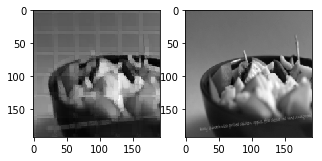

Testing Data : [0/14364 (0%)]	Loss: 201.215683
Time Spend : 1.7405390739440918
PNSR Data number 0 : 22.629406344057816



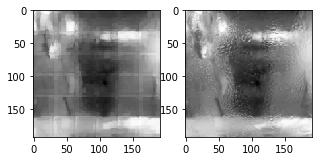

Testing Data : [1/14364 (1%)]	Loss: 230.470413
Time Spend : 1.619537353515625
PNSR Data number 1 : 22.039872338148406



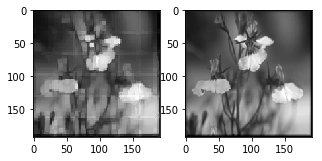

Testing Data : [2/14364 (2%)]	Loss: 158.247803
Time Spend : 1.7613279819488525
PNSR Data number 2 : 23.672647531371297



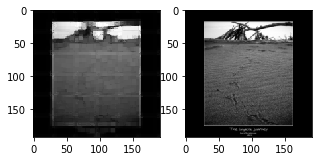

Testing Data : [3/14364 (3%)]	Loss: 203.226349
Time Spend : 1.6377835273742676
PNSR Data number 3 : 22.586224752319097



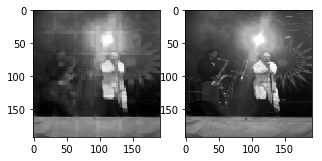

Testing Data : [4/14364 (4%)]	Loss: 106.165344
Time Spend : 1.6770174503326416
PNSR Data number 4 : 25.406196890294094



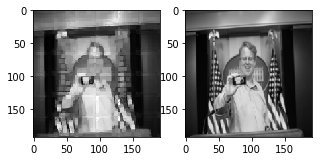

Testing Data : [5/14364 (5%)]	Loss: 288.324005
Time Spend : 1.635570764541626
PNSR Data number 5 : 21.067216724920893



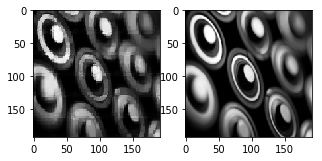

Testing Data : [6/14364 (6%)]	Loss: 311.887939
Time Spend : 1.6344141960144043
PNSR Data number 6 : 20.72603860334884



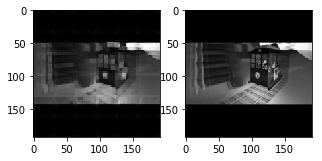

Testing Data : [7/14364 (7%)]	Loss: 110.087578
Time Spend : 1.644911527633667
PNSR Data number 7 : 25.24864156106173



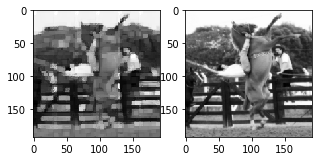

Testing Data : [8/14364 (8%)]	Loss: 404.513062
Time Spend : 1.6839442253112793
PNSR Data number 8 : 19.596698671264093



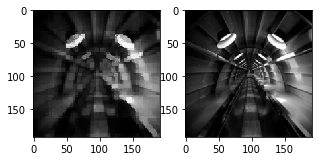

Testing Data : [9/14364 (9%)]	Loss: 199.206635
Time Spend : 1.653426170349121
PNSR Data number 9 : 22.67298679813034

Testing Result =====>
Loss : 221.334481048584
Psnr Average : 22.564593021491664
Testing Success


In [16]:
import time
print("Begin Testing...")
network.eval()
loss_temp = 0
counter = 0
block_size = 32
psnr_temp = 0

for batch_idx,(data,_) in enumerate(test_loader):
  start_ins = time.time()
  data = Variable(data)

  result = data.clone()
  # print(result.shape)
  for i in range(0,192,block_size):
    for j in range(0,192,block_size):
      sep = result[0][0][i:i+block_size,j:j+block_size]
      sep = sep.unsqueeze(0)
      sep = sep.unsqueeze(0)
      # print(sep.shape)
      recon_sep,_,_,_ = network(sep.cuda())
      # print(recon_sep.shape)
      result[0][0][i:i+block_size,j:j+block_size] = recon_sep
  
  temp_fig = plt.figure(batch_idx,figsize=(5,15))

  temp_fig.add_subplot(1,2,1)
  plt.imshow(result[0][0].detach().cpu().numpy(),cmap=plt.get_cmap('gray'))

  temp_fig.add_subplot(1,2,2)
  plt.imshow(data[0][0].numpy(),cmap=plt.get_cmap('gray'))

  loss_value = loss(data.cuda(),result.cuda())
  loss_temp += loss_value.item()/len(data)
  end_ins = time.time()
  
  psnr_ins = psnr(data[0][0].numpy(),result[0][0].detach().cpu().numpy())

  psnr_temp += psnr_ins/len(data)
  
  plt.show()
  
  print('Testing Data : [{}/{} ({:.0f}%)]\tLoss: {:.6f}\nTime Spend : {}'.format(
                batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss_value.item() / len(data),
                end_ins - start_ins
                ))
  print('PNSR Data number {} : {}\n'.format(counter,psnr_ins))
  counter = counter+1
                 
print("Testing Result =====>\nLoss : {}\nPsnr Average : {}".format((loss_temp/len(test_loader)),(psnr_temp/len(test_loader))))
print("Testing Success")

Data - 0 : 10.55915104607006

Data - 1 : 12.83685473924499

Data - 2 : 12.151685917695985

Data - 3 : 10.085208618085328

Data - 4 : 13.001426193772701

Data - 5 : 15.593995128828212

Data - 6 : 14.984608955822276

Data - 7 : 12.02926623878755

Data - 8 : 15.846323411266365

Data - 9 : 13.616520727793242



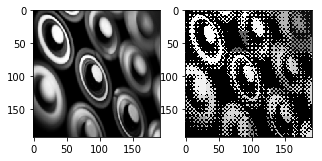

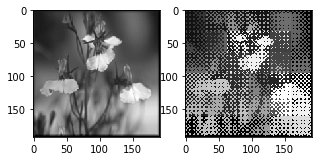

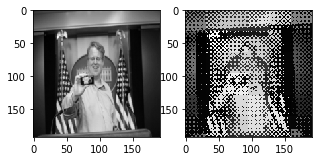

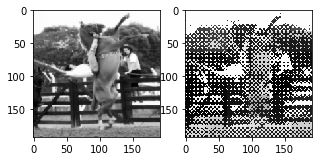

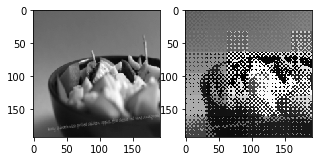

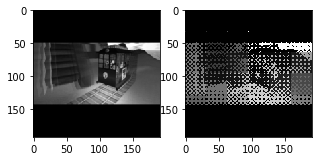

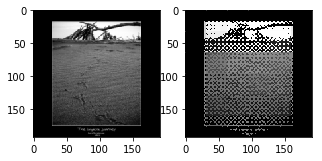

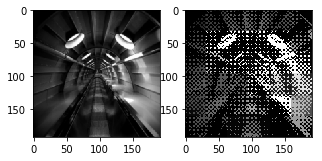

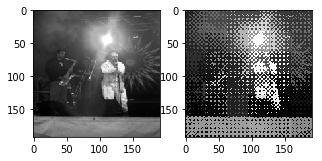

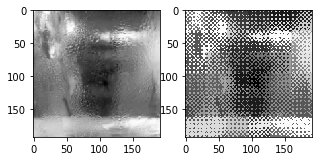

In [17]:
odbtc = ODBTC(32)
for batch_idx,(data,_) in enumerate(test_loader):
  data_numpy = data.clone().numpy()
  data_numpy = data_numpy[0]

  temp_od = odbtc(data_numpy)

  temp_fig = plt.figure(batch_idx,figsize=(5,15))

  temp_fig.add_subplot(1,2,1)
  plt.imshow(data[0][0].numpy(),cmap=plt.get_cmap('gray'))

  temp_fig.add_subplot(1,2,2)
  plt.imshow(temp_od[0],cmap=plt.get_cmap('gray'))

  print("Data - {} : {}\n".format(batch_idx,psnr(data[0][0].numpy(),temp_od[0])))